# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

In [2]:
# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')

## Option B: Synthetic Generator

In [3]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [4]:
# create at least two features
df['lag_1'] = df['ret'].shift(1)
df['lag_3'] = df['ret'].shift(3)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_vol_5'] = df['ret'].rolling(5).std().shift(1)

df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,lag_3,roll_mean_5,roll_vol_5,y_next_ret,y_up
2021-01-08,101.063685,0.000321,0.000321,-0.007561,0.000628,-0.001379,0.004642,0.000291,1
2021-01-11,101.093108,0.000291,0.000291,0.000321,0.004385,-0.001315,0.004668,-0.017099,0
2021-01-12,99.364481,-0.017099,-0.017247,0.000291,-0.007561,-0.000387,0.004365,0.010532,1
2021-01-13,100.410953,0.010532,0.010477,-0.017099,0.000321,-0.003933,0.008539,0.006325,1
2021-01-14,101.046042,0.006325,0.006305,0.010532,0.000291,-0.002703,0.010297,-0.005937,0


## Split

In [5]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','lag_3','roll_mean_5','roll_vol_5']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']

## Pipeline + Model

In [6]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = mean_squared_error(y_te_reg, pred, squared=False)
r2 = r2_score(y_te_reg, pred)
print('RMSE:', rmse)
print('R2:', r2)

RMSE: 0.014498961176713777
R2: 0.0036964481138015426


## Plot

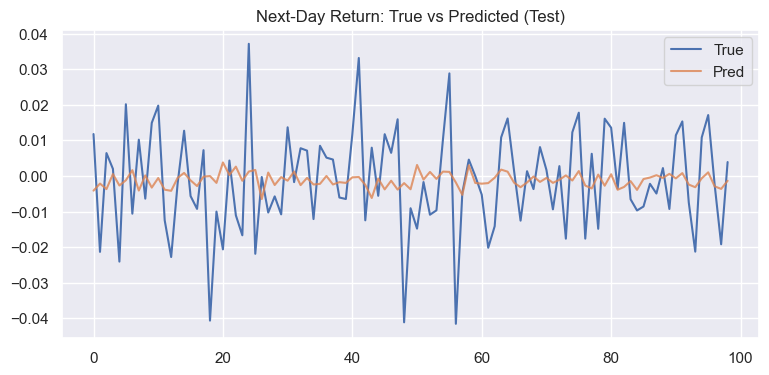

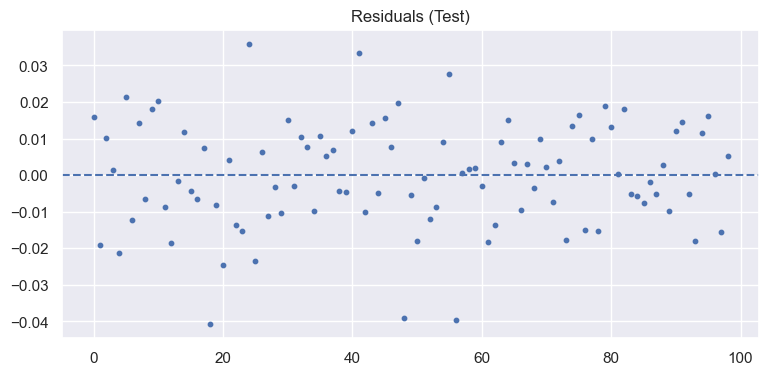

In [7]:
fig, ax = plt.subplots()
y_te_reg.reset_index(drop=True).plot(ax=ax, label='True')
pd.Series(pred).plot(ax=ax, label='Pred', alpha=0.8)
ax.set_title('Next-Day Return: True vs Predicted (Test)')
ax.legend(); plt.show()

resid = y_te_reg.values - pred
fig, ax = plt.subplots()
ax.scatter(range(len(resid)), resid, s=10)
ax.axhline(0, ls='--')
ax.set_title('Residuals (Test)'); plt.show()

## Interpretation
- What worked?
  - Pipeline correctly handles scaling and regression, preventing data leakage.
  - Lagged returns and rolling statistics capture some temporal structure.
  - RMSE is small, meaning prediction errors are not very large in absolute terms.
- Where might assumptions fail?
  - Normality: Heavy tails from jumps violate the Gaussian assumption underlying linear regression.
- How would you extend features or model?
  - Regularization (Ridge/Lasso) to handle collinearity.
  - Tree-based models (Random Forest, XGBoost) to capture nonlinearities.
  - Time-series models (ARIMA, GARCH, LSTM) for dynamics and volatility.
  - Classification track (predict y_up) might perform better than raw regression.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.